In [63]:
#ライブラリ
import pandas as pd
import numpy as np
from sklearn.model_selection import cross_validate
from datetime import datetime
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

from sklearn.model_selection import TimeSeriesSplit
import statsmodels.api as sm

import lightgbm as lgb

In [64]:
#データの準備
train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')
sample = pd.read_csv('data/sample.csv' , index_col = 0 , header=None)

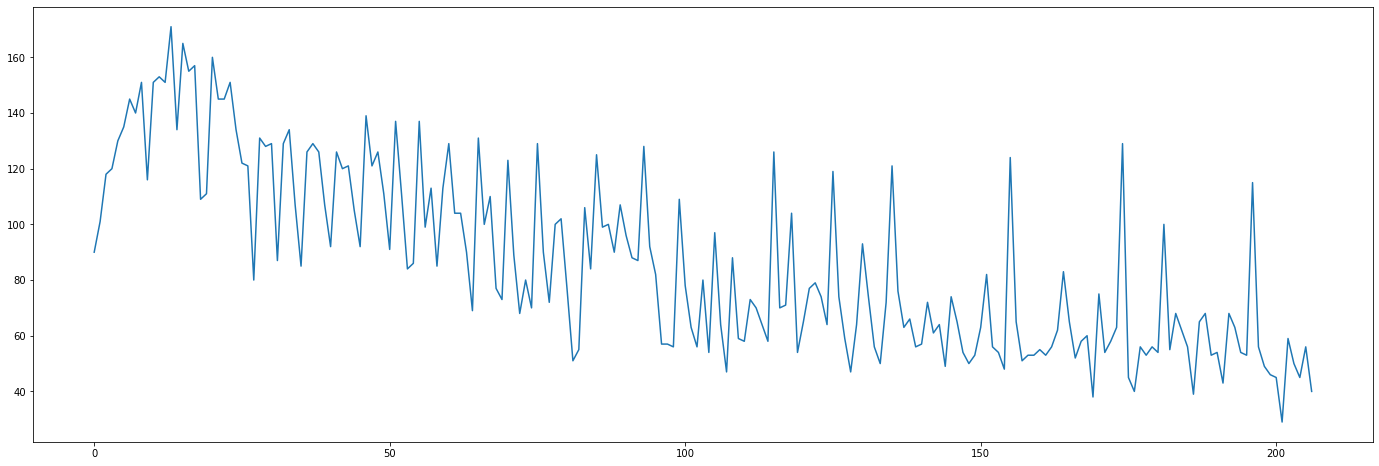

In [65]:
fig = plt.figure(figsize=(24,8))
plt.plot(train['y'])
plt.show()

メモ
- はじめの数十レコードは傾向が違いそう
- 右下がりのトレンド
- スパイクが多数存在。※何かの理由により異常値のような数値変化が発生している箇所。（だと思う）

In [66]:
train.describe(include=('all'))

,datetime,y,week,soldout,name,kcal,remarks,event,payday,weather,precipitation,temperature
count,207,207.000000,207,207.000000,207,166.000000,21,14,10.0,207,207,207.000000
unique,207,NaN,5,NaN,156,NaN,6,2,NaN,7,8,NaN
top,2013-11-18,NaN,水,NaN,メンチカツ,NaN,お楽しみメニュー,ママの会,NaN,快晴,--,NaN
freq,1,NaN,43,NaN,6,NaN,12,9,NaN,53,169,NaN
mean,NaN,86.623188,NaN,0.449275,NaN,404.409639,NaN,NaN,1.0,NaN,NaN,19.252174
std,NaN,32.882448,NaN,0.498626,NaN,29.884641,NaN,NaN,0.0,NaN,NaN,8.611365
min,NaN,29.000000,NaN,0.000000,NaN,315.000000,NaN,NaN,1.0,NaN,NaN,1.200000
25%,NaN,57.000000,NaN,0.000000,NaN,386.000000,NaN,NaN,1.0,NaN,NaN,11.550000
50%,NaN,78.000000,NaN,0.000000,NaN,408.500000,NaN,NaN,1.0,NaN,NaN,19.800000
75%,NaN,113.000000,NaN,1.000000,NaN,426.000000,NaN,NaN,1.0,NaN,NaN,26.100000


In [67]:
test.describe(include='all')

,datetime,week,soldout,name,kcal,remarks,event,payday,weather,precipitation,temperature
count,40,40,40.000000,40,36.000000,7,3,2.0,40,40,40.000000
unique,40,5,NaN,38,NaN,3,2,NaN,5,5,NaN
top,2014-10-1,水,NaN,麻婆豆腐,NaN,お楽しみメニュー,キャリアアップ支援セミナー,NaN,快晴,--,NaN
freq,1,9,NaN,2,NaN,4,2,NaN,12,31,NaN
mean,NaN,NaN,0.425000,NaN,421.083333,NaN,NaN,1.0,NaN,NaN,18.665000
std,NaN,NaN,0.500641,NaN,13.626392,NaN,NaN,0.0,NaN,NaN,4.401838
min,NaN,NaN,0.000000,NaN,396.000000,NaN,NaN,1.0,NaN,NaN,9.200000
25%,NaN,NaN,0.000000,NaN,411.500000,NaN,NaN,1.0,NaN,NaN,15.250000
50%,NaN,NaN,0.000000,NaN,420.000000,NaN,NaN,1.0,NaN,NaN,19.000000
75%,NaN,NaN,1.000000,NaN,428.500000,NaN,NaN,1.0,NaN,NaN,21.650000


In [68]:
train.shape

(207, 12)

In [69]:
#trainから数十レコードを削除
train = train.drop(train.index[:25]).reset_index()

In [70]:
train.head()

,index,datetime,y,week,soldout,name,kcal,remarks,event,payday,weather,precipitation,temperature
0,25,2013-12-24,122,火,0,さっくりメンチカツ,NaN,NaN,NaN,NaN,快晴,--,11.5
1,26,2013-12-25,121,水,1,手ごね風ハンバーグ,NaN,NaN,NaN,NaN,快晴,--,8.0
2,27,2013-12-26,80,木,0,酢豚,NaN,NaN,NaN,NaN,曇,--,7.3
3,28,2014-1-7,131,火,0,カレー入りソーセージカツ,404.0,NaN,NaN,NaN,快晴,--,7.3
4,29,2014-1-8,128,水,0,豚肉の生姜焼,462.0,NaN,NaN,NaN,曇,--,9.8


/var/folders/ww/2r82ppr146b3q904dk54t0mr0000gn/T/ipykernel_2524/4136881508.py:6: RuntimeWarning: overflow encountered in exp
  return a * np.exp(-b * x) + c


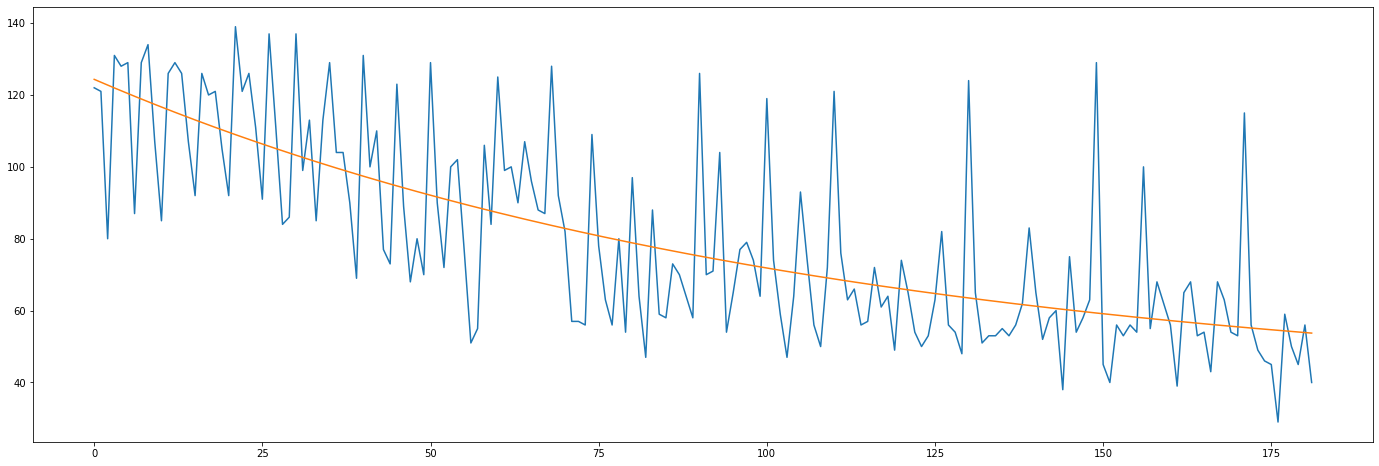

In [71]:
#トレンドを除いた目的関数を作成
#最小二乗法によるカーブフィッティングでトレンドを抽出して、販売数から引き算する。
from scipy.optimize import curve_fit

def func(x , a , b , c):
    return a * np.exp(-b * x) + c

xs = train.index.values
ys = train['y'].values

popt , pcov = curve_fit(func , xs , ys)

a1 , b1 , c1 = popt
y_reg = a1 * np.exp(-b1 * xs) + c1

plt.figure(figsize=(24,8))
plt.plot(train['y'])
plt.plot(y_reg)

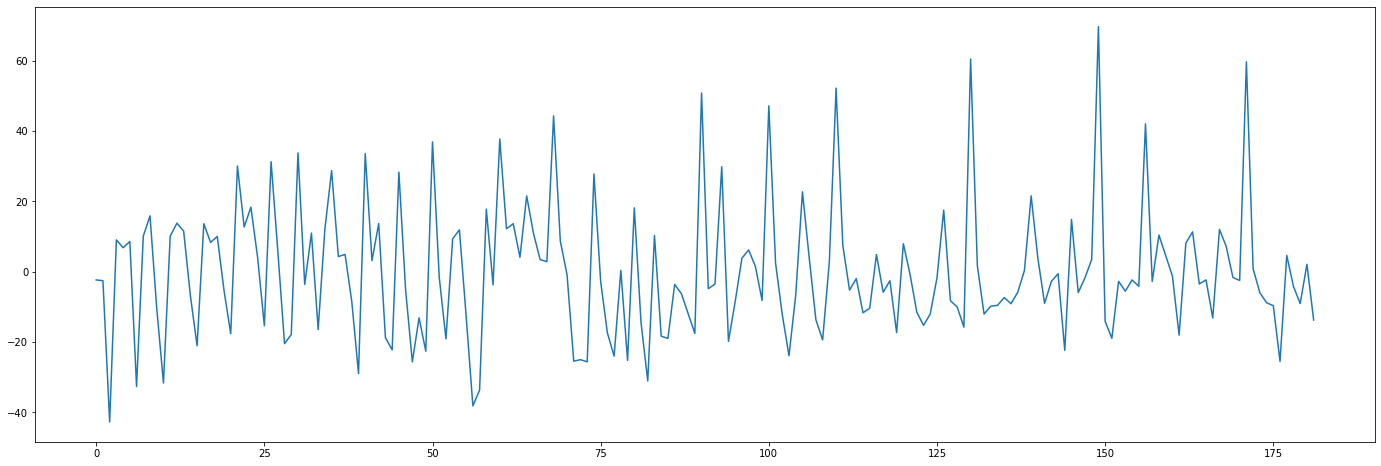

In [77]:
#トレンドを除去する
new_y = train['y'] - y_reg
new_y = pd.DataFrame({'new_y':new_y})

fig = plt.figure(figsize=(24,8))
plt.plot(new_y)
plt.show()

In [79]:
#特徴量エンジニアリング
#splitして月と日にちの部分だけ利用※ただ、テストデータのみに存在する月があるため、月は利用せず。
train['day'] = train['datetime'].apply(lambda x : int(x.split('-')[2]))